# Time Series Exploratory Data Analysis

## Introduction

The objective of this project is to define a clear exploratory data analysis template, focused on time series, which can summarize and highlight the most important characteristics of the dataset.

## Data

The dataset: [PJM Hourly Energy Consumption](https://www.kaggle.com/datasets/robikscube/hourly-energy-consumption) 

This dataset relates to PJM, a regional transmission organization that serves electricity to many states in the United States.

The hourly power consumption data comes from PJM’s website and are in megawatts (MW).

## EDA Overview

The EDA in this project consists on 6 steps:
- Descriptive Statistics
- Time Plot
- Seasonal Plots
- Box Plots
- Time Series Decomposition
- Lag Analysis.

`Note:` Graphs can highlight many features, such as patterns, unusual observations, changes over time, and relationships between variables.

## Descriptive Statistics

Descriptive statistic is a summary statistic that quantitatively describes or summarizes features from a collection of structured data.

Some metrics that are commonly used:
- measures of central tendency (e.g. *mean, median*)
- measures of dispersion (e.g. *range, standard deviation*)
- measure of position (e.g. *percentiles, quartile*)

Do **five number summary** (quartile) with pandas:

In [2]:
import pandas as pd

# Loading and preprocessing steps
df = pd.read_csv('./data/PJME_hourly.csv')
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)

df.describe()

,PJME_MW
count,145366.000000
mean,32080.222831
std,6464.012166
min,14544.000000
25%,27573.000000
50%,31421.000000
75%,35650.000000
max,62009.000000


## Time plot

The observations are plotted against the time they were observed, with consecutive observations joined by lines.

Text(0.5, 0, 'Date')

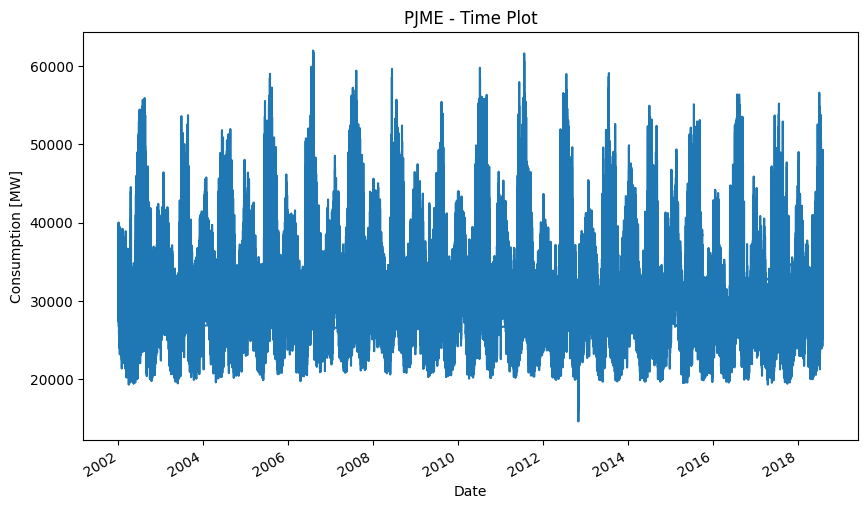

In [3]:
import matplotlib.pyplot as plt

df['PJME_MW'].plot(title='PJME - Time Plot', figsize=(10,6))
plt.ylabel('Consumption [MW]')
plt.xlabel('Date')

`Note:`
- As we could expect, the pattern shows yearly seasonality.
- Focusing on a single year, it seems that more pattern emerges. Likely, the consumptions will have a peak in winter and one another in summer, due to the greater electricity consumption.
- The series does not exhibit a clear increasing/decreasing trend over the years, the average consumptions remains stationary.
- There is an anomalous value around 2023, probably it should be imputed when implementing the model.

## Seasonal Plots

A seasonal plot is where data are plotted against the individual “seasons” of the series they belong.

Regarding energy consumption, we usually have hourly data available, so there could be several seasonality: yearly, weekly, daily.

In [4]:
# Defining required fields
df['year'] = df.index.year
df['month'] = df.index.month
df['week'] = df.index.isocalendar().week  # More efficient way to get the week number
df['hour'] = df.index.hour
df['day'] = df.index.dayofweek  # Use .dayofweek instead of apply
df['day_str'] = df.index.strftime('%a')  # Directly use strftime on the index
df['year_month'] = df.index.to_period('M').astype(str)  # Efficient year_month extraction

df.head(3)

,PJME_MW,year,month,week,hour,day,day_str,year_month
Datetime,,,,,,,,
2002-12-31 01:00:00,26498.0,2002,12,1,1,1,Tue,2002-12
2002-12-31 02:00:00,25147.0,2002,12,1,2,1,Tue,2002-12
2002-12-31 03:00:00,24574.0,2002,12,1,3,1,Tue,2002-12


### Yearly consumption

This plot highlights yearly seasonality and can inform us about ascending/descending trends over the years.

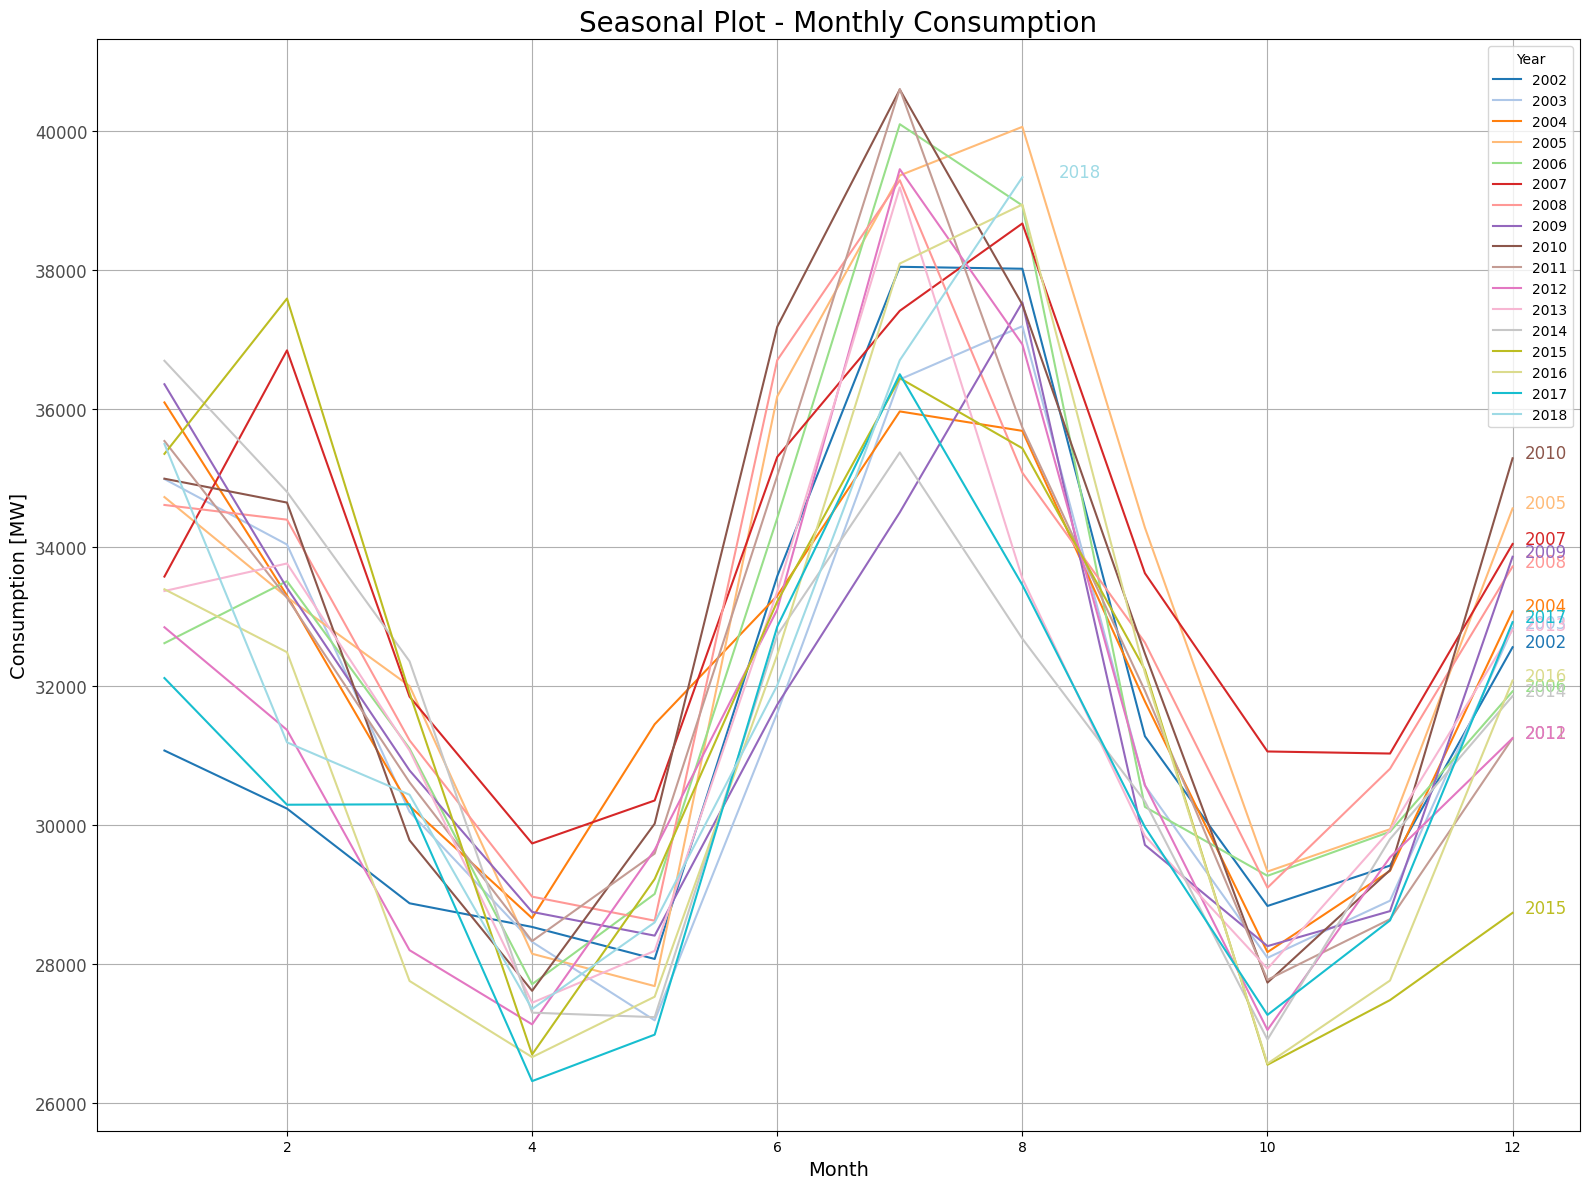

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Defining colors palette
np.random.seed(42)
df_plot = df[['month', 'year', 'PJME_MW']].dropna().groupby(['month', 'year']).mean().reset_index()

years = df_plot['year'].unique()

# Using a color map to automatically generate distinct colors
cmap = plt.get_cmap('tab20', len(years))  # Use tab20 colormap, which has 20 distinct colors

# Plot
plt.figure(figsize=(16, 12))

for i, y in enumerate(years):
    df_year = df_plot[df_plot['year'] == y]  # Slice the data once for each year
    plt.plot(df_year['month'], df_year['PJME_MW'], color=cmap(i), label=y)
    
    # Efficiently place text annotations at the end of each year
    last_value = df_year['PJME_MW'].iloc[-1]  # Get the last value for the year
    x_pos = df_year['month'].iloc[-1] + (0.3 if y == 2018 else 0.1)  # Slight offset for 2018
    plt.text(x_pos, last_value, str(y), fontsize=12, color=cmap(i))

# Setting labels and formatting the plot
plt.ylabel('Consumption [MW]', fontsize=14)
plt.xlabel('Month', fontsize=14)
plt.title("Seasonal Plot - Monthly Consumption", fontsize=20)
plt.yticks(fontsize=12, alpha=0.7)
plt.grid(which='both')
plt.legend(title='Year', fontsize=10)
plt.tight_layout()  # Adjust the layout to prevent overlap
plt.show()


`Note:`
- every year has actually a very predefined pattern: the consumption increases significantly during winter and has a peak in summer (due to heating/cooling systems), while has a minima in spring and in autumn when no heating or cooling is usually required.
- that’s not a clear increasing/decreasing pattern in the overall consumptions across years.

### Weekly consumption

The plot depicts the consumptions during the week over months and can also suggest if and how weekly consumptions are changing over a single year.

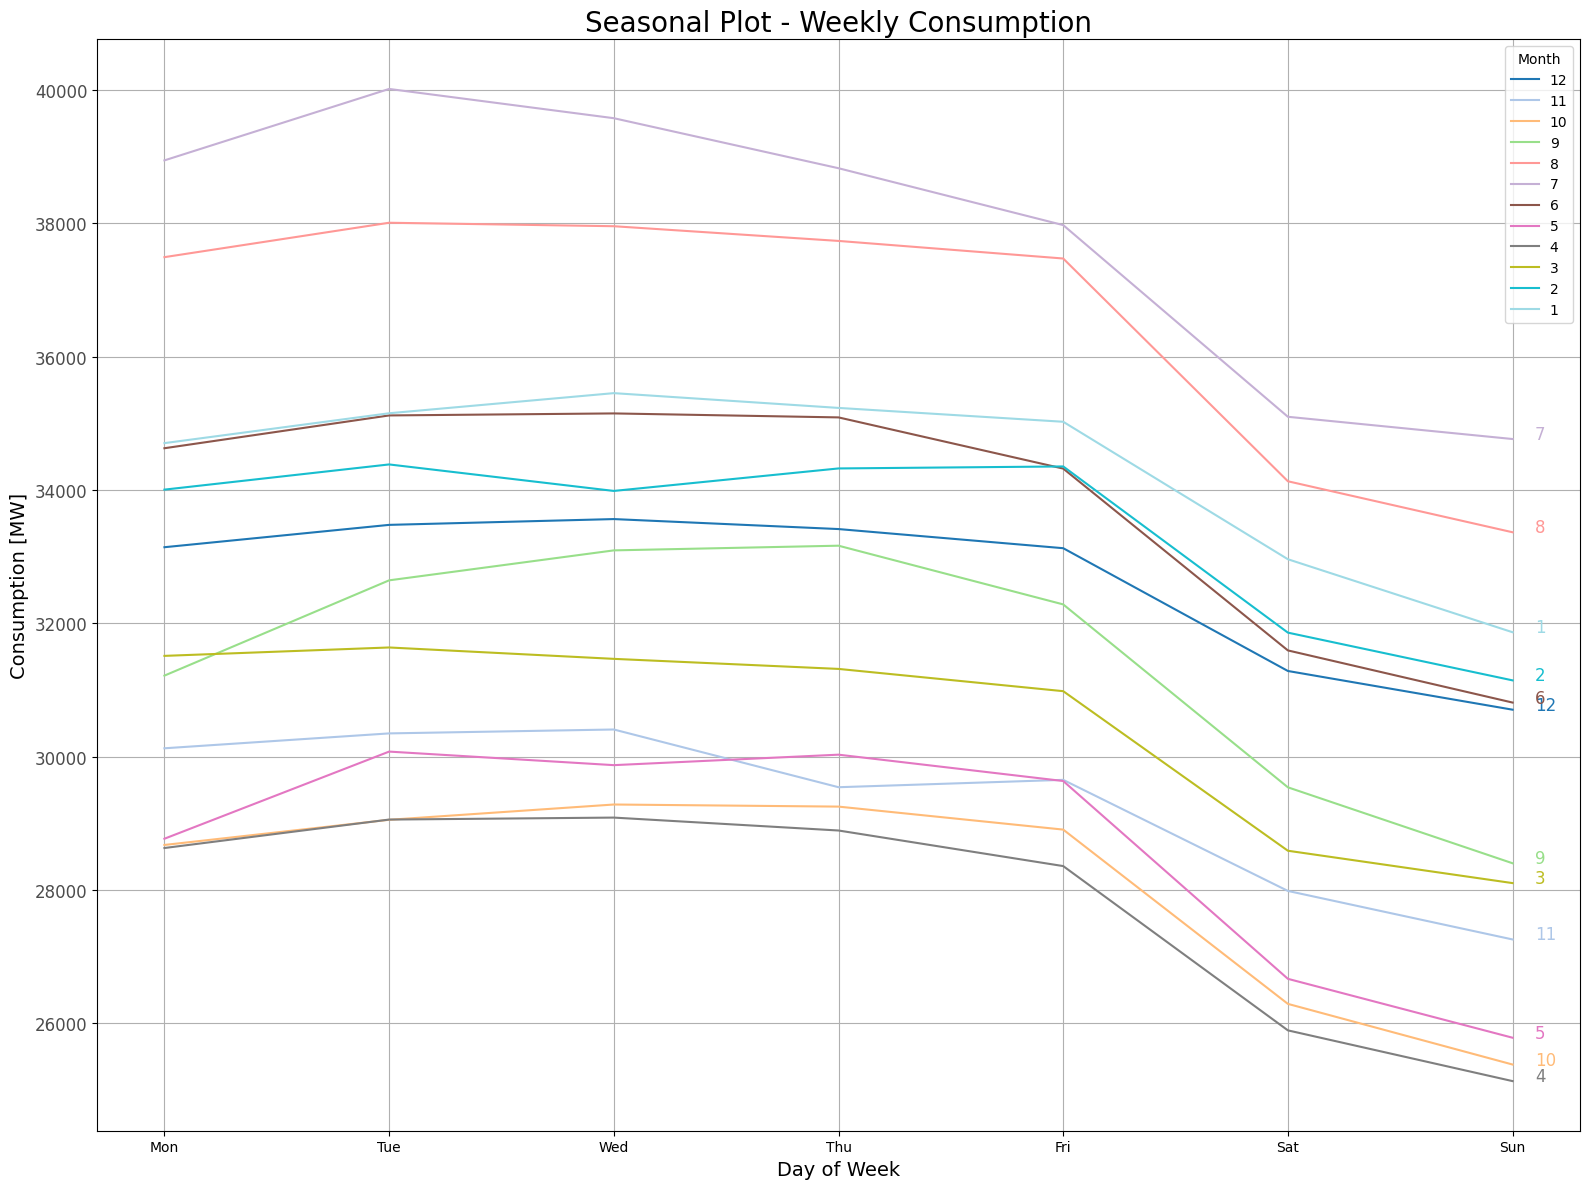

In [6]:
# Defining colors palette
np.random.seed(42)
df_plot = df[['month', 'day_str', 'PJME_MW', 'day']].dropna().groupby(['day_str', 'month', 'day']).mean().reset_index()

# Sorting by 'day' for easier plotting
df_plot = df_plot.sort_values(by='day', ascending=True)
months = df_plot['month'].unique()

# Using a colormap for better color management
cmap = plt.get_cmap('tab20', len(months))  # Use 'tab20' colormap for up to 20 distinct colors

# Plot
plt.figure(figsize=(16, 12))
for i, month in enumerate(months):
    df_month = df_plot[df_plot['month'] == month]  # Slicing once per month for efficiency
    plt.plot(df_month['day_str'], df_month['PJME_MW'], color=cmap(i), label=month)
    
    # Annotating the last point of each month's plot
    last_value = df_month['PJME_MW'].iloc[-1]  # Get the last PJME_MW value for the month
    plt.text(len(df_month['day_str']) - 0.9, last_value, str(month), fontsize=12, color=cmap(i))

# Setting Labels
plt.ylabel('Consumption [MW]', fontsize=14)
plt.xlabel('Day of Week', fontsize=14)  # Changed label to be more specific
plt.title("Seasonal Plot - Weekly Consumption", fontsize=20)
plt.yticks(fontsize=12, alpha=.7)
plt.legend(title='Month', fontsize=10)
plt.tight_layout()
plt.grid()
plt.show()


### Daily consumption

it represents how consumption change over the day. In this case, data are first grouped by day of week and then aggregated taking the mean.

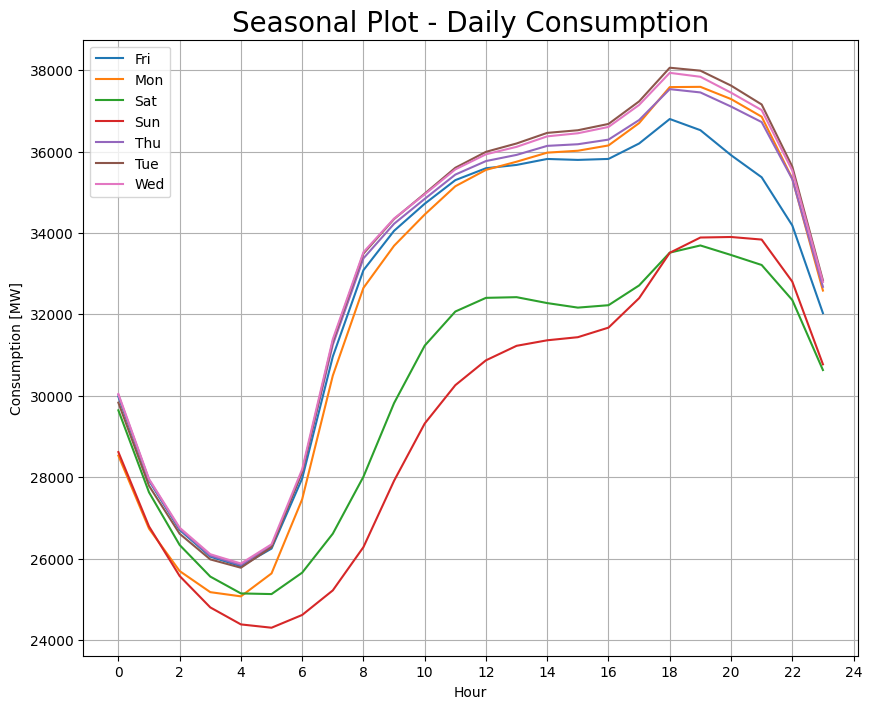

In [7]:
import seaborn as sns

# Defining the dataframe
df_plot = df[['hour', 'day_str', 'PJME_MW']].dropna().groupby(['hour', 'day_str']).mean()[['PJME_MW']].reset_index()

# Plot using Seaborn
plt.figure(figsize=(10,8))
sns.lineplot(data = df_plot, x='hour', y='PJME_MW', hue='day_str', legend=True)
plt.locator_params(axis='x', nbins=24)
plt.title("Seasonal Plot - Daily Consumption", fontsize=20)
plt.ylabel('Consumption [MW]')
plt.xlabel('Hour')
plt.grid()
plt.legend()

Often, this plot show a very typical pattern (“M profile”) since consumptions seems to depict an “M” during the day. Sometimes this pattern is clear, others not (like in this case).

However, this plots usually shows a relative peak in the middle of the day (from 10 am to 2 pm), then a relative minima (from 2 pm to 6 pm) and another peak (from 6 pm to 8 pm). Finally, it also shows the difference in consumptions from weekends and other days.

### Feature Engineering

Let’s suppose we are using some ML model that requires good quality features (e.g. ARIMA models or tree-based models).

These are the main evidences coming from seasonal plots:

1. **Yearly consumptions do not change a lot over years**: this suggests the possibility to use, when available, yearly seasonality features coming from lag or exogenous variables.
2. **Weekly consumptions follow the same pattern across months**: this suggests to use weekly features coming from lag or exogenous variables.
3. **Daily consumption differs from normal days and weekends**: this suggest to use categorical features able to identify when a day is a normal day and when it is not.

## Box Plots

Boxplot are a useful way to identify how data are distributed. Briefly, boxplots depict percentiles, which represent 1st (Q1), 2nd (Q2/median) and 3rd (Q3) quartile of a distribution and whiskers, which represent the range of the data. Every value beyond the whiskers can be thought as an outlier, more in depth, whiskers are often computed as:
$$w_1=Q1-1.5\cdot(Q3-Q1)$$
$$w_2=Q3+1.5\cdot(Q3-Q1)$$

### Total consumption

[]

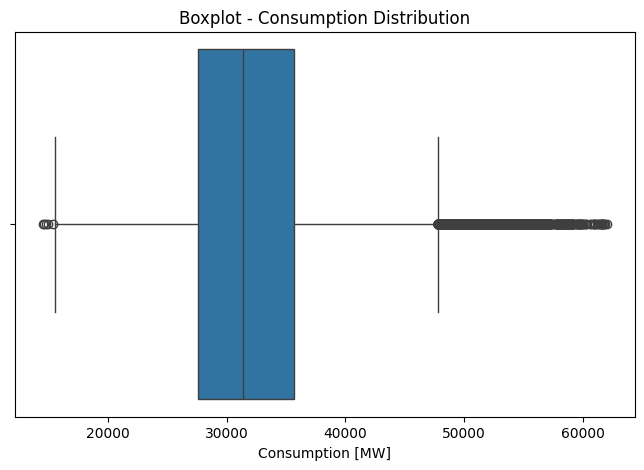

In [8]:
plt.figure(figsize=(8,5))
sns.boxplot(data=df, x='PJME_MW')
plt.xlabel('Consumption [MW]')
plt.title(f'Boxplot - Consumption Distribution')
plt.plot()

`Note:` we are dealing with a Gaussian-like distribution, with a tail more accentuated towards the right.

### Day month distribution

The plot is obtained creating a “day month” variable and grouping consumptions by it.

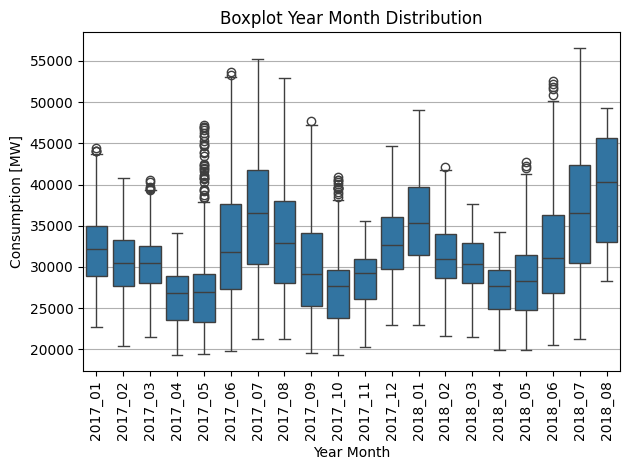

In [9]:
df['year_month'] = df.index.to_series().dt.strftime('%Y_%m')

df_plot = df[df['year'] >= 2017].sort_index()
plt.title(f'Boxplot Year Month Distribution')
plt.xticks(rotation=90)
plt.xlabel('Year Month')
plt.ylabel('MW')

sns.boxplot(x='year_month', y='PJME_MW', data=df_plot)
plt.ylabel('Consumption [MW]')
plt.xlabel('Year Month')
plt.tight_layout()
plt.grid(axis='y')
plt.show()

`Note:`
- consumption are less uncertain in summer/winter months (i.e. when we have peaks) while are more dispersed in spring/autumn (i.e. when temperatures are more variable).
- consumption in summer 2018 are higher than 2017, maybe due to a warmer summer.

When feature engineering, remember to include (if available) the temperature curve, probably it can be used as an exogenous variable.

### Day distribution

THe plot refers consumption distribution over the week, this is similar to the weekly consumption seasonal plot.

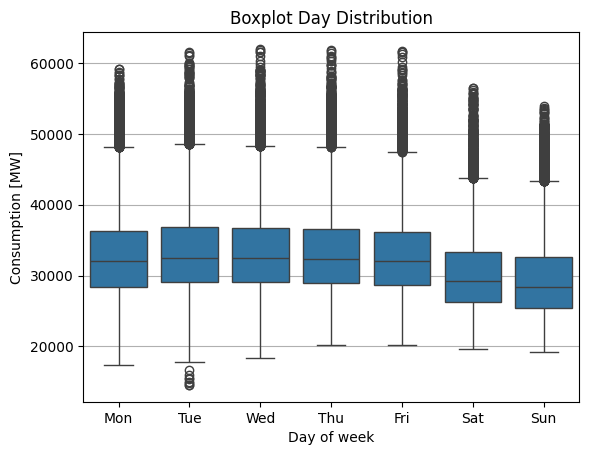

In [10]:
df_plot = df[['day_str', 'day', 'PJME_MW']].sort_values(by='day')
plt.title(f'Boxplot Day Distribution')
plt.xlabel('Day of week')
plt.ylabel('MW')
sns.boxplot(x='day_str', y='PJME_MW', data=df_plot)
plt.ylabel('Consumption [MW]')
plt.xlabel('Day of week')
plt.grid(axis='y')
plt.show()

`Note:`
- consumptions are noticeably lower on weekends.
- there are several outliers pointing out that calendar features like “day of week” for sure are useful but could not fully explain the series.

### Hour distribution

This plot is similar to the daily consumption seasonal plot since it provides how consumptions are distributed over the day.

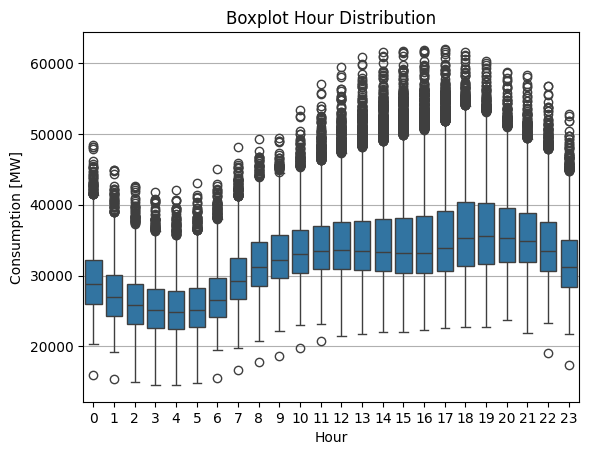

In [11]:
plt.title(f'Boxplot Hour Distribution');
plt.xlabel('Hour')
plt.ylabel('MW')
sns.boxplot(x='hour', y='PJME_MW', data=df)
plt.ylabel('Consumption [MW]')
plt.xlabel('Hour')
plt.grid(axis='y')
plt.show()

`Note:`
- the “M” shape seen before is now much more crushed.
- there are a lot of outliers, this tells us data not only relies on daily seasonality (e.g. the consumption on today’s 12 am is similar to the consumption of yesterday 12 am) but also on something else, probably some exogenous climatic feature like temperature or humidity.

## Time Series Decomposition

Time series data can exhibit a variety of patterns. Often, it is helpful to split a time series into several components, each representing an underlying pattern category.

There are 3 components:
- a *trend* component
- a *seasonal* component
- a *remainder* component (containing anything else in the time series)

For some time series, there can be more than one seasonal component, corresponding to different seasonal periods (daily, weekly, monthly, yearly).

There are two main type of decomposition (with series (𝑦), a seasonal component (𝑆), a trend (𝑇) and a remainder (𝑅)):
- additive:
$$y_t=S_t+T_t+R_t$$
- multiplicative:
$$y_t=S_t\times T_t\times R_t$$

Additive decomposition best represent series with constant variance while multiplicative decomposition best suits time series with non-stationary variances.

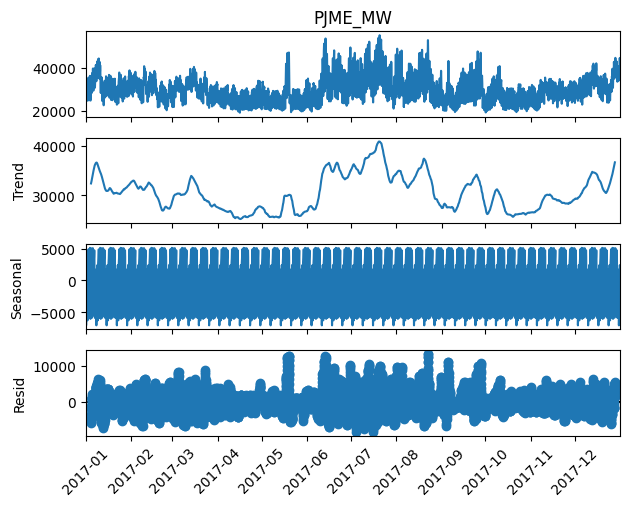

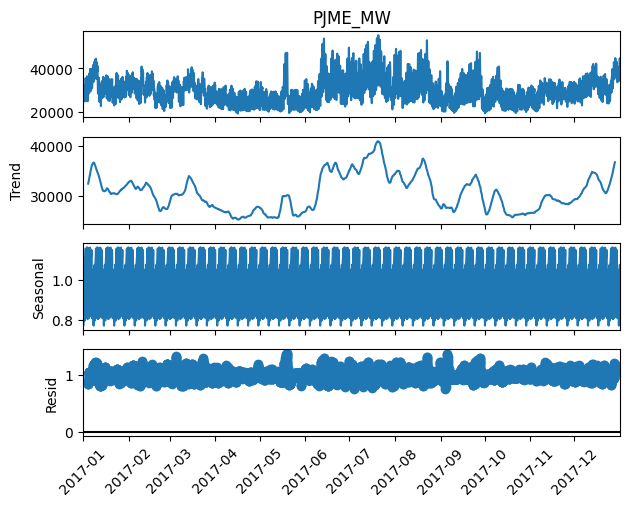

In [12]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Filter, reset index, drop duplicates, and sort efficiently in one line
df_plot = df[df['year'] == 2017].reset_index().drop_duplicates(subset='Datetime').sort_values(by='Datetime').set_index('Datetime')

# Performing Additive and Multiplicative Decomposition
period = 24 * 7
result_add = seasonal_decompose(df_plot['PJME_MW'], model='additive', period=period)
result_mul = seasonal_decompose(df_plot['PJME_MW'], model='multiplicative', period=period)

# Plot
result_add.plot().suptitle('', fontsize=12)
plt.xticks(rotation=45)
result_mul.plot().suptitle('', fontsize=12)
plt.xticks(rotation=45)
plt.show()

`Note:`
-  In both cases, the trend has several local peaks, with higher values in summer.
- From the seasonal component, the series actually has several periodicities, this plot highlights more the weekly one, but if we focus on a particular month (January) of the same year, daily seasonality emerges too:

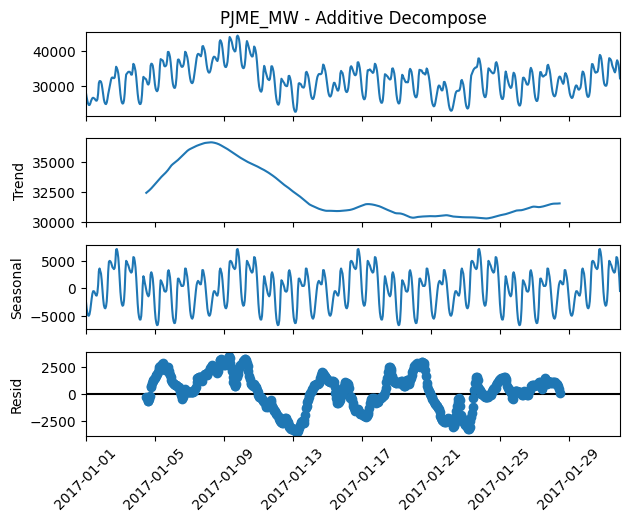

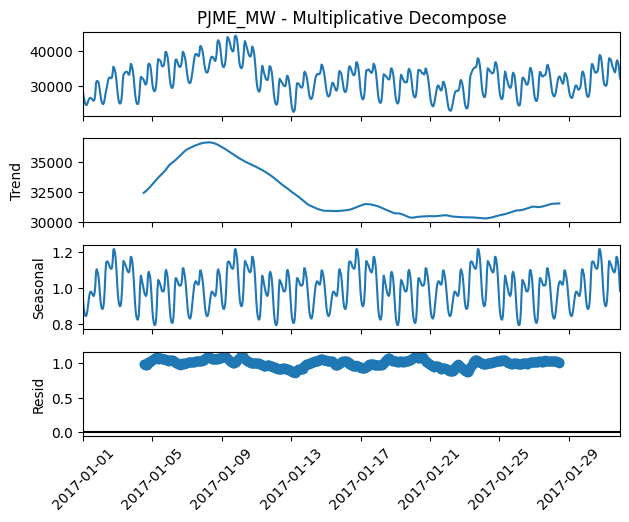

In [13]:
df_plot = df[(df['year'] == 2017)].reset_index()
df_plot = df_plot[df_plot['month'] == 1]
df_plot['PJME_MW - Multiplicative Decompose'] = df_plot['PJME_MW']
df_plot['PJME_MW - Additive Decompose'] = df_plot['PJME_MW']

df_plot = df_plot.drop_duplicates(subset=['Datetime']).sort_values(by='Datetime')
df_plot = df_plot.set_index('Datetime')

# Additive Decomposition
result_add = seasonal_decompose(df_plot['PJME_MW - Additive Decompose'], model='additive', period=24*7)

# Multiplicative Decomposition 
result_mul = seasonal_decompose(df_plot['PJME_MW - Multiplicative Decompose'], model='multiplicative', period=24*7)

# Plot
result_add.plot().suptitle('', fontsize=22)
plt.xticks(rotation=45)
result_mul.plot().suptitle('', fontsize=22)
plt.xticks(rotation=45)
plt.show()

## Lag Analysis

A lag is simply a past value of the series. e.g., for daily series, the first lag refers to the value the series had the previous day, and so on.

Lag analysis is based on computing correlations between the series and a lagged version of the series itself, this is also called *autocorrelation*.

For a k-lagged version of a series, we define the autocorrelation coefficient as:

$$r_k=\frac{\sum_{t=k+1}^T(y_t-\overline{y})(y_{t-k}-\overline{y})}{\sum_{t=1}^T(y_t-\overline{y})^2}$$

- $\overline{y}$: the mean value of the series
- $k$: the lag.

The autocorrelation coefficients make up the *autocorrelation function* (ACF) for the series, this is a plot depicting the auto-correlation coefficient versus the number of lags taken into consideration.

- When data has a trend, the autocorrelations for small lags are usually large and positive because observations close in time are also nearby in value.
- When data show seasonality, autocorrelation values will be larger in correspondence of seasonal lags (and multiples of the seasonal period) than for other lags.
- Data with both trend and seasonality will show a combination of these effects.

In practice, a more useful function is the *partial autocorrelation function* (PACF). It is similar to the ACF, except that it shows only the direct autocorrelation between two lags. e.g., the partial autocorrelation for lag 3 refers to the only correlation lag 1 and 2 do not explain. In other words, the partial correlation refers to the direct effect a certain lag has on the current time value, removing the effects of intermediate lags:
$$X_t=\alpha+\phi_1X_{t-1}+\phi_2X_{t-2}+...+\phi_kX_{t-k}+\epsilon_t$$

- the PACF simply consists on plotting Pearson partial auto-correlation coefficients for different lags.
- Of course, the non-lagged series shows a perfect auto-correlation with itself, so lag 0 will always be 1.
- The blue band represent the *confidence interval*: if a lag exceed that band, then it is statistically significant and we can assert it is has great importance.

Autocorrelation coefficient emerges more clearly if the series is *stationary*, so often is better to first differentiate the series to stabilize the signal.

PACF for different hours of the day:

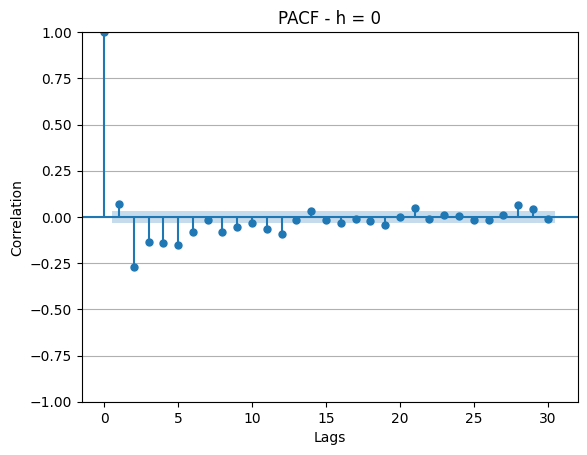

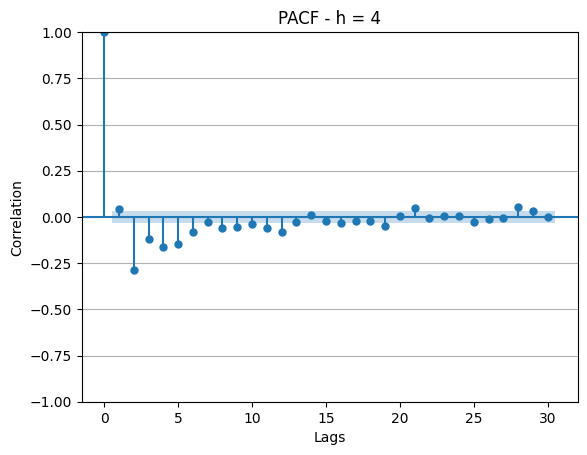

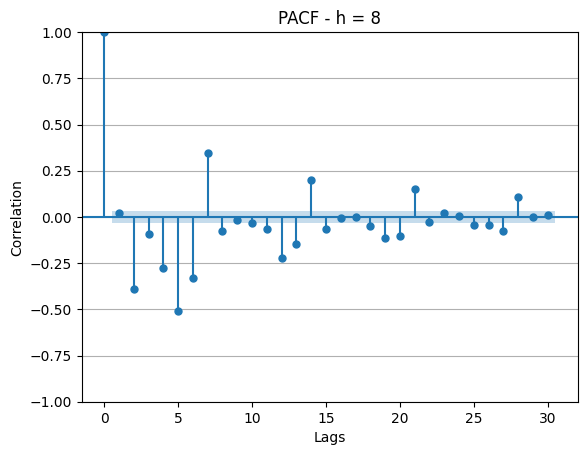

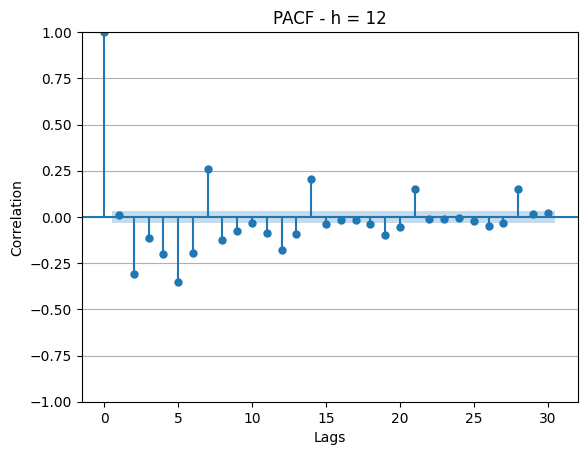

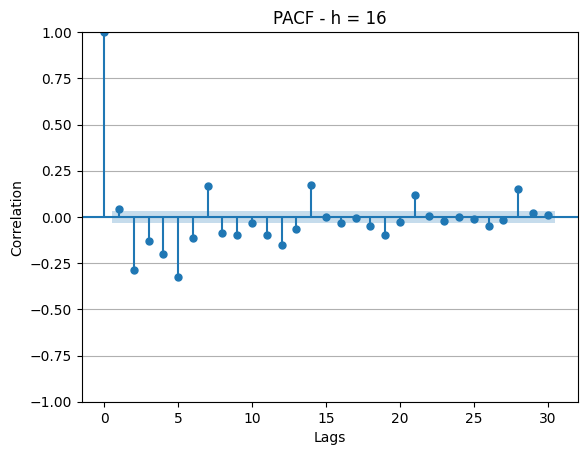

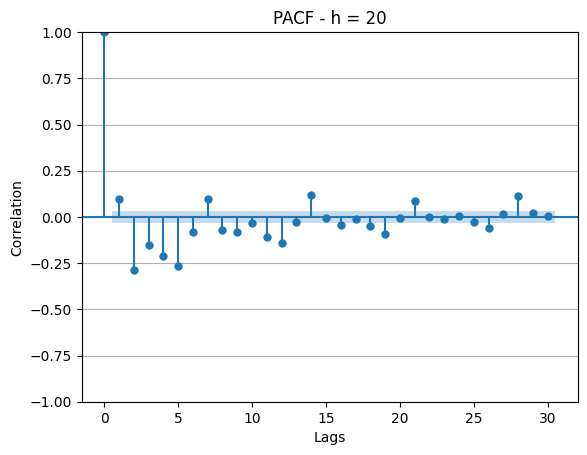

In [15]:
from statsmodels.graphics.tsaplots import plot_pacf

actual = df['PJME_MW']
hours = range(0, 24, 4)

for hour in hours:
    plot_pacf(actual[actual.index.hour == hour].diff().dropna(), lags=30, alpha=0.01)
    plt.title(f'PACF - h = {hour}')
    plt.ylabel('Correlation')
    plt.xlabel('Lags')
    plt.grid(axis='y')
    plt.show()

**Night Hours**

Consumption on night hours (0, 4) relies more on **auto-regressive** than on weekly lags, since the most important are all localized on the first five. Seasonal periods such as 7, 14, 21, 28 seems not to be too much important, this advises us to pay particular attention on lag 1 to 5 when feature engineering.

**Day Hours**

Consumption on day hours (8, 12, 16, 20) exhibit both **auto-regressive** and **seasonal lags**. This particularly true for hours 8 and 12 - when consumption is particularly high — while seasonal lags become less important approaching the night. For these subsets we should also include seasonal lag as well as auto-regressive ones.

`Note:` 2 types of lag we can deal with when doing lag analysis:

1. **Auto-regressive lags**: lags close to lag 0, for which we expect high values (recent lags are more likely to predict the present value). They are a representation on how much trend the series shows.
2. **Seasonal lags**: lags referring to seasonal periods. When hourly splitting the data, they usually represent weekly seasonality.

Note that auto-regressive lag 1 can also be taught as a *daily seasonal lag* for the series.

### Feature Engineering

a lag with high correlation is an important lag for the series.

some tips when feature engineering lags:

- Do not to take into consideration too many lags since this will probably lead to over fitting. Generally, auto-regressive lags goes from 1 to 7, while weekly lags should be 7, 14, 21 and 28. But it’s not mandatory to take each of them as features.
- Taking into consideration lags that are not auto-regressive or seasonal is usually a bad idea since they could bring to overfitting as well. Rather, try to understand while a certain lag is important.
- Transforming lags can often lead to more powerful features. For example, seasonal lags can be aggregated using a weighted mean to create a single feature representing the seasonality of the series.

# Reference

[Time Series Forecasting: A Practical Guide to Exploratory Data Analysis](https://towardsdatascience.com/time-series-forecasting-a-practical-guide-to-exploratory-data-analysis-a101dc5f85b1)